In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [11]:
def plot_bars(df, figsize=(14, 8), label_size=16, tick_size=14, bar_width=0.5, **kwargs):

    mae_lim = kwargs.pop('mae_lim', (10, 60))
    annotate_size = kwargs.pop('annotate_size', tick_size-1)
    
    # Set plot style
    sns.set_style("whitegrid")

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=figsize)

    if "TSD" in df['Task'].unique():

        # Plot MAE bar chart for TSD
        tsd_plot = sns.barplot(
            data=df[df['Task'] == 'TSD'],
            x='Task', 
            y='Performance', 
            hue='Model',
            dodge=True,
            ax=ax1,
            palette='Blues',
            width=bar_width
        )

        # Annotate bars with their values
        for p in tsd_plot.patches:
            if p.get_height() == 0:
                continue
            height = p.get_height()
            tsd_plot.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=annotate_size, color='blue')

        # Set left axis label
        ax1.set_xlabel('Task', fontsize=label_size, fontweight='bold')
        ax1.set_ylabel('MAE(←)', color='tab:blue', fontsize=label_size, fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=tick_size)
        ax1.tick_params(axis='x', labelsize=tick_size)
        handles1, labels1 = ax1.get_legend_handles_labels()
        ax1.legend(loc='upper left', fontsize=tick_size-1)
        ax1.set_ylim(*mae_lim)

        # Create second y-axis
        ax2 = ax1.twinx()
    else:
        ax2 = ax1

    # Plot ACC bar chart for other tasks
    acc_plot = sns.barplot(
        data=df[df['Task'] != 'TSD'],
        x='Task', 
        y='Performance', 
        hue='Model',
        dodge=True,
        ax=ax2,
        palette='Greens',
        width=bar_width
    )

    # Annotate bars with their values
    for p in acc_plot.patches:
        if p.get_height() == 0:
            continue
        height = p.get_height()
        acc_plot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=annotate_size, color='green')

    # Set right axis label
    ax2.set_xlabel('Task', fontsize=label_size, fontweight='bold')
    ax2.set_ylabel('ACC(→)', color='tab:green', fontsize=label_size, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=tick_size)
    ax2.tick_params(axis='x', labelsize=tick_size)
    ax2.set_ylim(0, 1)
    if ax2 is not ax1:
        ax2.grid(False)

    # Merge legends and display only one set
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(loc='upper right', fontsize=tick_size-1)
    # ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))
    return fig


In [3]:
fig_dir = Path("./CGCNN_MT/evaluation/figures")

### Test set performance of retrained ML models and similar models in Nandy et al.’s and Terrones et al.’s work

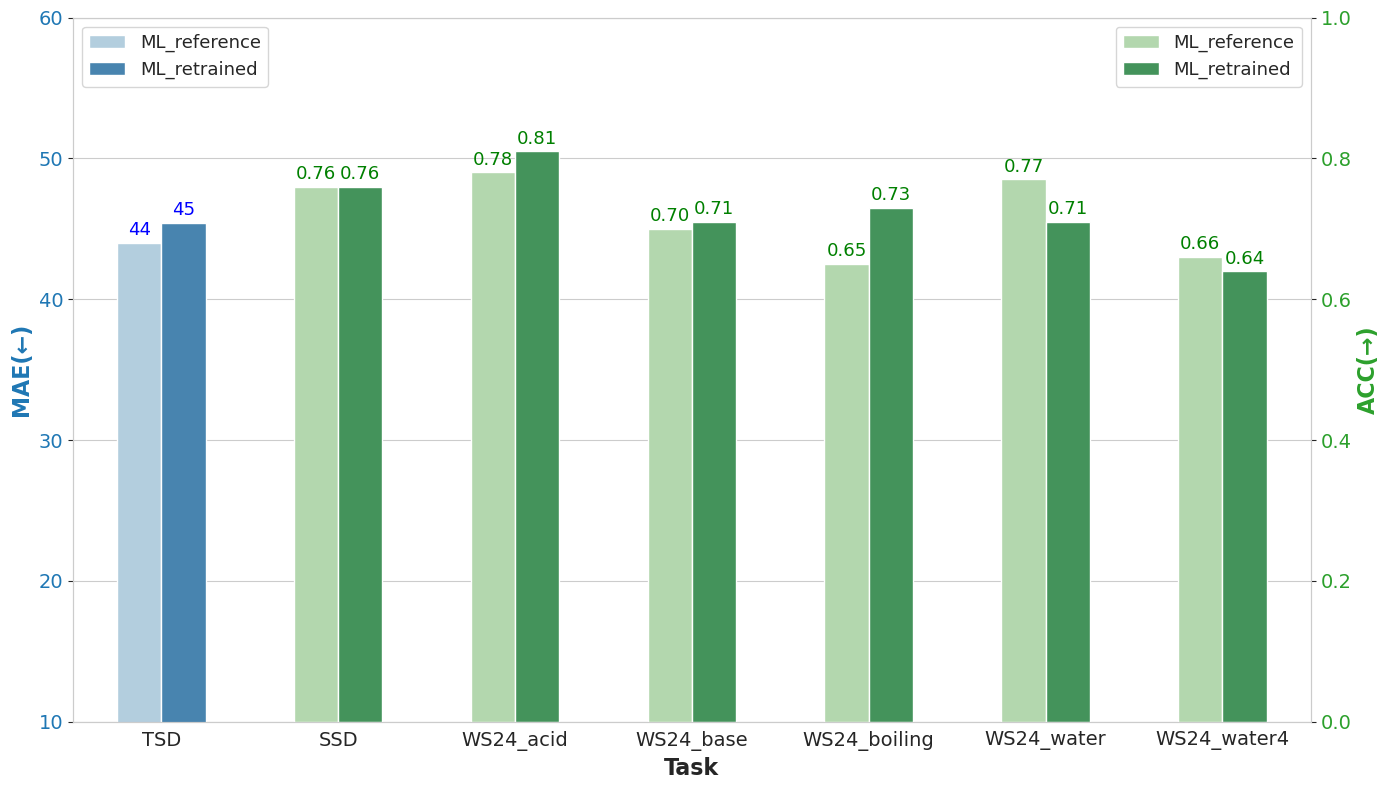

In [4]:
split = 'test'

mertics_file = f'./CGCNN_MT/evaluation/ML_results_{split}.xlsx'
# Read data
df = pd.read_excel(mertics_file, index_col=[0, 1]).reset_index().copy()
df["Model"] = df["Model"].apply(lambda x: "ML_reference" if x != "ML_retrained" else "ML_retrained")
df.sort_values(by=["Task", "Model"], inplace=True)

# Preprocess data, separate TSD and other tasks
tsd_data = df.loc[df['Task'] == 'TSD', ['Task', 'Model', 'MAE']]
other_tasks_data = df.loc[df['Task'] != 'TSD', ['Task', 'Model', 'ACC']]

# Combine relevant metrics (MAE for TSD and ACC for other tasks)
tsd_data = tsd_data.rename(columns={'MAE': 'Performance'}).dropna()
other_tasks_data = other_tasks_data.rename(columns={'ACC': 'Performance'}).dropna()
combined_data = pd.concat([tsd_data, other_tasks_data])

# Clean data, remove rows with NaN values
combined_data = combined_data.dropna()

# Draw figure
fig = plot_bars(combined_data, figsize=(14, 8), label_size=16, tick_size=14, bar_width=0.5)
# Set title and adjust layout
# plt.title('Model Performance Comparison across Different Tasks', fontsize=16, fontweight='bold')
plt.tight_layout()
fig.savefig(fig_dir/f"model_comparation_vis_ML_retrained.tif", dpi=96)
fig.savefig(fig_dir/f"model_comparation_vis_ML_retrained.svg", dpi=200, transparent=True)
# Display figure
plt.show()

### Test set/External test set performance of ML baseline models, single-task CGCNN models, CGCNN_MT model, and proposed MOFSNN model

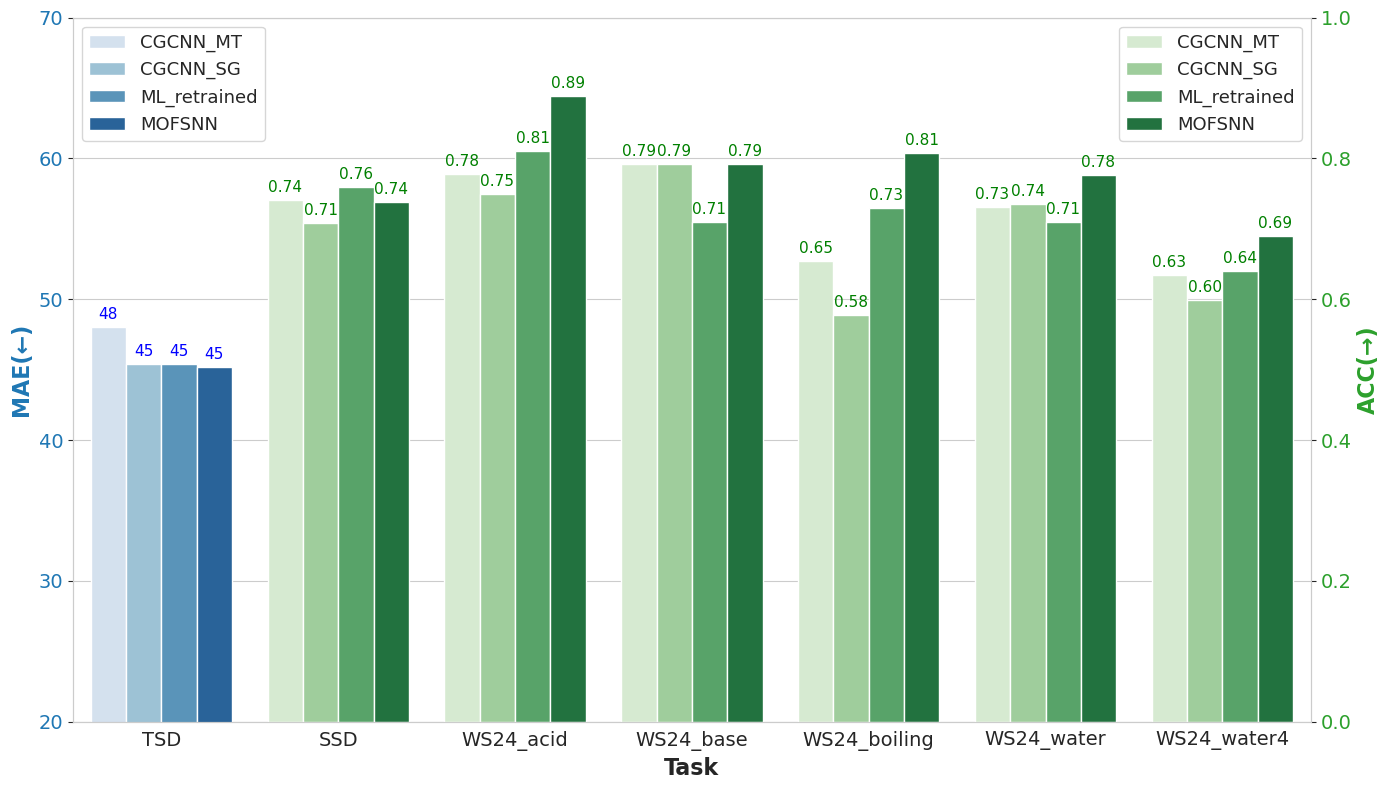

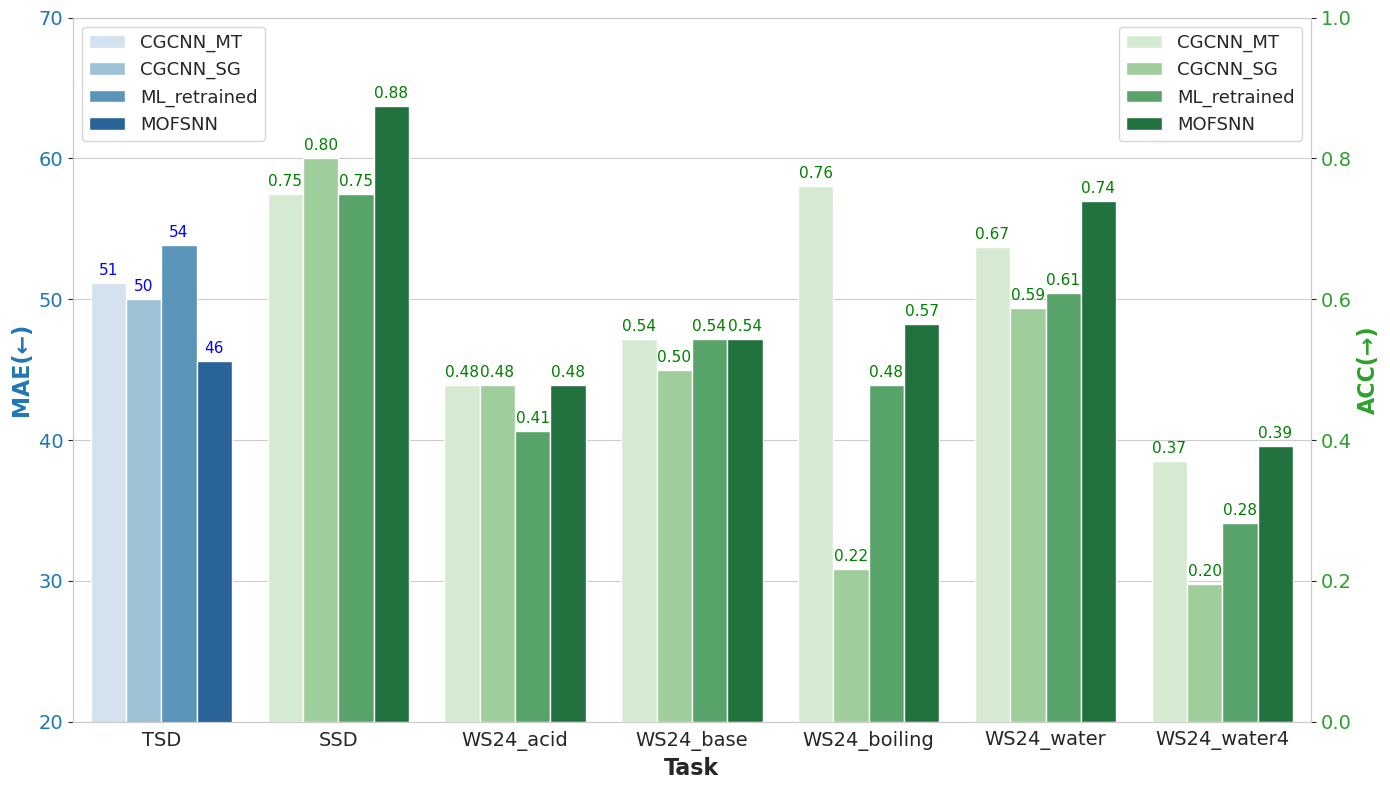

In [5]:
for split in ["test", "external_test"]:
    mertics_file = f'./CGCNN_MT/evaluation/CGCNN_ML_results_{split}.xlsx'
    # Read data
    df = pd.read_excel(mertics_file, index_col=[0, 1]).reset_index().copy()

    # Preprocess data, separate TSD and other tasks
    tsd_data = df.loc[df['Task'] == 'TSD', ['Task', 'Model', 'MAE']]
    other_tasks_data = df.loc[df['Task'] != 'TSD', ['Task', 'Model', 'ACC']]

    # Combine relevant metrics (MAE for TSD and ACC for other tasks)
    tsd_data = tsd_data.rename(columns={'MAE': 'Performance'}).dropna()
    other_tasks_data = other_tasks_data.rename(columns={'ACC': 'Performance'}).dropna()
    combined_data = pd.concat([tsd_data, other_tasks_data])

    # Clean data, remove rows with NaN values
    combined_data = combined_data.dropna()

    fig = plot_bars(combined_data, figsize=(14, 8), label_size=16, tick_size=14, bar_width=0.8, mae_lim=(20, 70), annotate_size=11)

    # Set title and adjust layout
    # plt.title('Model Performance Comparison across Different Tasks', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(fig_dir/f"model_comparation_vis_{split}.tif", dpi=96)
    plt.savefig(fig_dir/f"model_comparation_vis_{split}.svg", dpi=200, transparent=True)
    # Display figure
    plt.show()


### Test set performance of MOFSNN models trained with all seven datasets (MOFSNN_full) and five more strongly correlated datasets only (MOFSNN_strong_corr)

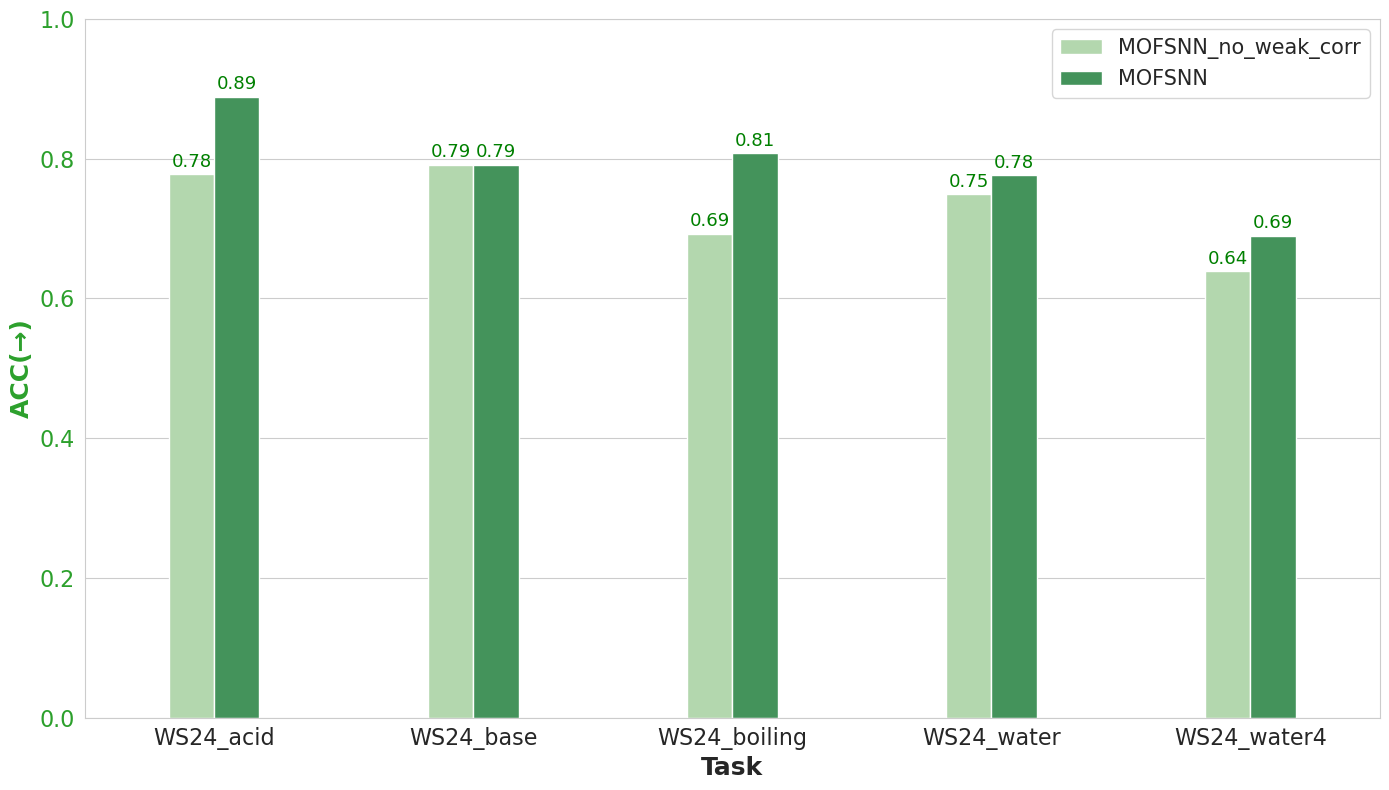

In [13]:
split = 'test'

mertics_file = f'./CGCNN_MT/evaluation/MOFSNN_subset_model_results_{split}.xlsx'
# Read data
df = pd.read_excel(mertics_file, index_col=[0, 1]).reset_index().copy()
df = df[df["Model"].isin(["MOFSNN", "MOFSNN_no_weak_corr"])]
df = df[~df["Task"].isin(["SSD", "TSD"])]
df.sort_values(by=["Task", "Model"], ascending=[True, False], inplace=True)

# Preprocess data, separate TSD and other tasks
tsd_data = df.loc[df['Task'] == 'TSD', ['Task', 'Model', 'MAE']]
other_tasks_data = df.loc[df['Task'] != 'TSD', ['Task', 'Model', 'ACC']]

# Combine relevant metrics (MAE for TSD and ACC for other tasks)
tsd_data = tsd_data.rename(columns={'MAE': 'Performance'}).dropna()
other_tasks_data = other_tasks_data.rename(columns={'ACC': 'Performance'}).dropna()
combined_data = pd.concat([tsd_data, other_tasks_data])

# Clean data, remove rows with NaN values
combined_data = combined_data.dropna()

# Set up figure
fig = plot_bars(combined_data, figsize=(14, 8), label_size=18, tick_size=16, bar_width=0.35, annotate_size=13)

# Set title and adjust layout
# plt.title('Model Performance Comparison across Different Tasks', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(fig_dir/f"model_comparation_vis_subset_test_weak_corr.tif", dpi=96)
plt.savefig(fig_dir/f"model_comparation_vis_subset_test_weak_corr.svg", dpi=200, transparent=True)
# Display figure
plt.show()

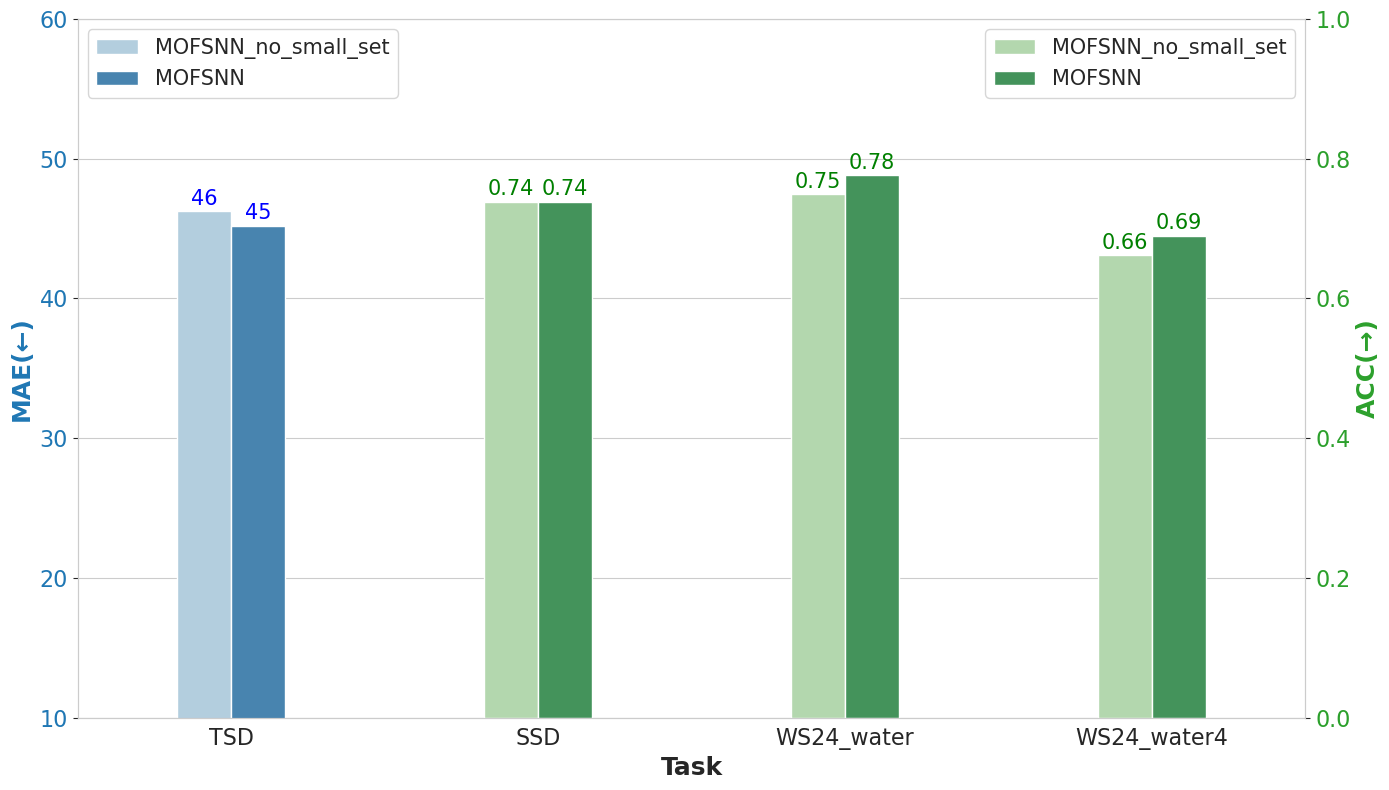

In [8]:
split = 'test'

mertics_file = f'./CGCNN_MT/evaluation/MOFSNN_subset_model_results_{split}.xlsx'
# Read data
df = pd.read_excel(mertics_file, index_col=[0, 1]).reset_index().copy()
df = df[df["Model"].isin(["MOFSNN", "MOFSNN_no_small_set"])]
df = df[~df["Task"].isin(["WS24_acid", "WS24_base", "WS24_boiling"])]
df.sort_values(by=["Task", "Model"], ascending=[True, False], inplace=True)

# Preprocess data, separate TSD and other tasks
tsd_data = df.loc[df['Task'] == 'TSD', ['Task', 'Model', 'MAE']]
other_tasks_data = df.loc[df['Task'] != 'TSD', ['Task', 'Model', 'ACC']]

# Combine relevant metrics (MAE for TSD and ACC for other tasks)
tsd_data = tsd_data.rename(columns={'MAE': 'Performance'}).dropna()
other_tasks_data = other_tasks_data.rename(columns={'ACC': 'Performance'}).dropna()
combined_data = pd.concat([tsd_data, other_tasks_data])

# Clean data, remove rows with NaN values
combined_data = combined_data.dropna()

fig = plot_bars(combined_data, figsize=(14, 8), label_size=18, tick_size=16, bar_width=0.35)

# Set title and adjust layout
# plt.title('Model Performance Comparison across Different Tasks', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(fig_dir/f"model_comparation_vis_subset_test_small_set.tif", dpi=96)
plt.savefig(fig_dir/f"model_comparation_vis_subset_test_small_set.svg", dpi=200, transparent=True)
# Display figure
plt.show()